<a href="https://colab.research.google.com/github/VijethAmin/TIME-SERIES-ANALYSIS-FOR-STOCK-MARKET.Myproject/blob/main/final_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')



8957


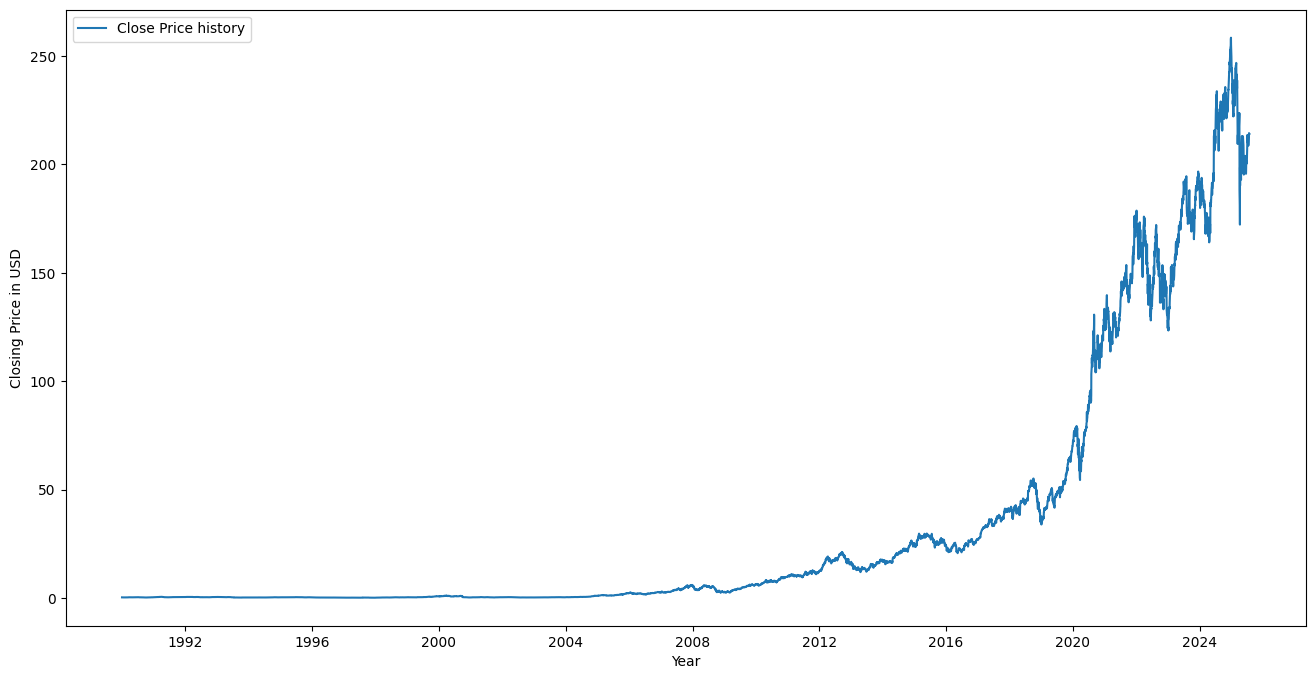

In [2]:
def stock_data(stock, start_date, end_date):
    ticker = yf.Ticker(stock)
    df = ticker.history(start=start_date, end=end_date)  # ✅ Removed period='1d'
    return df

# Now run
df = stock_data("AAPL", "1990-01-01", "2025-07-26")  # Up to today
print(df.shape[0])

# df = yf.download(ticker, start=start_date, end=end_date) # Removed this line

fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.plot(df['Close'], label='Close Price history')
plt.legend()
plt.show()

In [3]:
df.dtypes
df.describe()

df.reset_index(level="Date", inplace=True)
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [4]:
data = df.sort_index(ascending=True, axis=0)
df1 = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    df1["Date"][i] = data['Date'][i]
    df1["Close"][i] = data["Close"][i]


df1.index = df1.Date
df1.drop("Date", axis=1, inplace=True)
df1.head()

,Close
Date,
1990-01-02 00:00:00-05:00,0.261499
1990-01-03 00:00:00-05:00,0.263254
1990-01-04 00:00:00-05:00,0.264132
1990-01-05 00:00:00-05:00,0.265009
1990-01-08 00:00:00-05:00,0.266764


In [5]:
# Check for stationarity (ARIMA and SARIMA assume stationarity)
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05

is_stationary = check_stationarity(df1['Close'])

if not is_stationary:
    print("Data is not stationary. Applying differencing.")
    df1['Close_diff'] = df1['Close'].diff().dropna()
    check_stationarity(df1['Close_diff'].dropna())
else:
    print("Data is stationary.")

# Split data into training and testing sets
train_size = int(len(df1) * 0.8)
train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]

print(f"\nTraining set size: {len(train)}")
print(f"Test set size: {len(test)}")
print("\nTest set head:")
print(test.head())

# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['Close'].values.reshape(-1, 1))

# Prepare data for LSTM (create sequences)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 60 # Number of previous time steps to use as input features
trainX, trainY = create_dataset(scaled_data[0:train_size], look_back)
testX, testY = create_dataset(scaled_data[train_size:len(df1)], look_back)

# Reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(f"\nScaled data shape: {scaled_data.shape}")
print(f"TrainX shape: {trainX.shape}")
print(f"TrainY shape: {trainY.shape}")
print(f"TestX shape: {testX.shape}")
print(f"TestY shape: {testY.shape}")

ADF Statistic: 2.0898942497618034
p-value: 0.9987789577755852
Data is not stationary. Applying differencing.
ADF Statistic: -15.881627937937717
p-value: 8.74449210516259e-29

Training set size: 7165
Test set size: 1792

Test set head:
                               Close Close_diff
Date                                           
2018-06-08 00:00:00-04:00  45.346722  -0.416321
2018-06-11 00:00:00-04:00  45.235538  -0.111183
2018-06-12 00:00:00-04:00   45.48391   0.248371
2018-06-13 00:00:00-04:00  45.110161  -0.373749
2018-06-14 00:00:00-04:00  45.133812   0.023651

Scaled data shape: (8957, 1)
TrainX shape: (7104, 60, 1)
TrainY shape: (7104,)
TestX shape: (1731, 60, 1)
TestY shape: (1731,)


Root Mean Squared Error (SARIMA): 82.51557550728687

SARIMA MAE: 72.6294998423422
SARIMA MSE: 6808.8202012987595


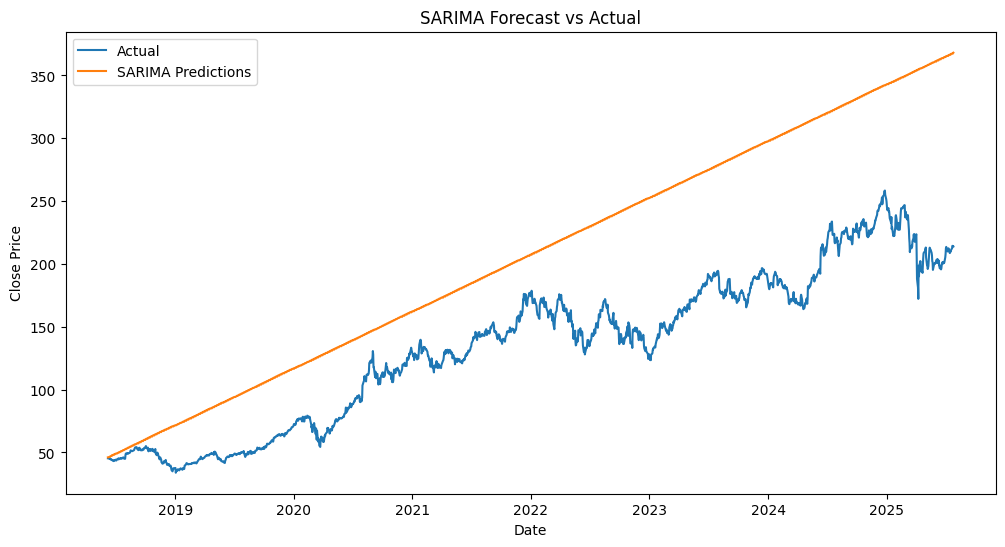

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Redefine train and test to match the split used for LSTM and ARIMA
train_sarima = df1.iloc[0:train_size].copy() # Use .copy() to avoid SettingWithCopyWarning
test_sarima = df1.iloc[train_size:len(df1)].copy() # Use .copy() to avoid SettingWithCopyWarning

train_sarima['Close'] = pd.to_numeric(train_sarima['Close']) # Ensure data type is numeric
train_sarima.index = pd.to_datetime(train_sarima.index) # Ensure index is datetime
test_sarima['Close'] = pd.to_numeric(test_sarima['Close']) # Ensure data type is numeric
test_sarima.index = pd.to_datetime(test_sarima.index) # Ensure index is datetime


sarima_model = SARIMAX(train_sarima['Close'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 5))
sarima_model = sarima_model.fit()

# Predict over the test period using the test set index
sarima_predictions = sarima_model.forecast(steps=len(test_sarima))
sarima_predictions.index = test_sarima.index # Align predictions with the test set index


sarima_rmse = math.sqrt(mean_squared_error(test_sarima['Close'], sarima_predictions))
print(f"Root Mean Squared Error (SARIMA): {sarima_rmse}")

# Evaluate SARIMA model (Optional, if you want MAE and MSE here)
sarima_mae = mean_absolute_error(test_sarima['Close'], sarima_predictions)
sarima_mse = mean_squared_error(test_sarima['Close'], sarima_predictions)
metrics['SARIMA'] = {'MAE': sarima_mae, 'MSE': sarima_mse}

print(f"\nSARIMA MAE: {sarima_mae}")
print(f"SARIMA MSE: {sarima_mse}")

# Plot SARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima['Close'], label='Actual')
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predictions')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

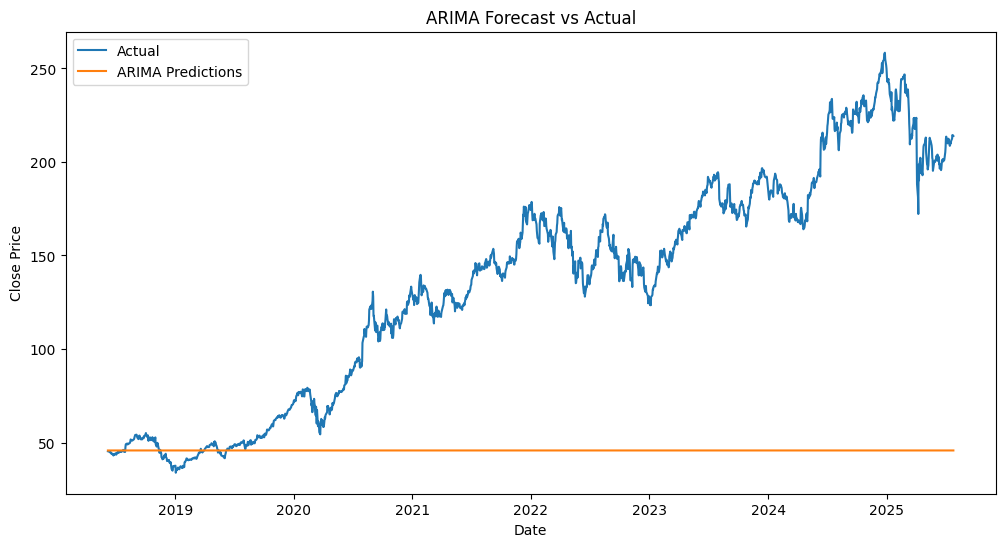


ARIMA MAE: 89.17663794673481
ARIMA MSE: 11447.565689720175


In [68]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Use the same train/test split as the other models
train_arima = df1.iloc[0:train_size].copy() # Use .copy() to avoid SettingWithCopyWarning
test_arima = df1.iloc[train_size:len(df1)].copy() # Use .copy() to avoid SettingWithCopyWarning

train_arima['Close'] = pd.to_numeric(train_arima['Close']) # Ensure data type is numeric
train_arima.index = pd.to_datetime(train_arima.index) # Ensure index is datetime
test_arima['Close'] = pd.to_numeric(test_arima['Close']) # Ensure data type is numeric
test_arima.index = pd.to_datetime(test_arima.index) # Ensure index is datetime

try:
    model_arima = ARIMA(train_arima['Close'], order=(5, 1, 0)) # Sample order
    model_arima_fit = model_arima.fit()

    # Make predictions - ensure predictions are aligned with the test set index
    arima_predictions = model_arima_fit.forecast(steps=len(test_arima))
    arima_predictions.index = test_arima.index # Align predictions with the test set index


    # Plot ARIMA predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_arima.index, test_arima['Close'], label='Actual')
    plt.plot(arima_predictions.index, arima_predictions, label='ARIMA Predictions')
    plt.title('ARIMA Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Evaluate ARIMA model
    arima_mae = mean_absolute_error(test_arima['Close'], arima_predictions)
    arima_mse = mean_squared_error(test_arima['Close'], arima_predictions)
    metrics['ARIMA'] = {'MAE': arima_mae, 'MSE': arima_mse}

    print(f"\nARIMA MAE: {arima_mae}")
    print(f"ARIMA MSE: {arima_mse}")

except Exception as e:
    print(f"An error occurred during ARIMA modeling: {e}")

In [6]:
metrics = {}

Epoch 1/3
711/711 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - loss: 1.1627e-04
Epoch 2/3
711/711 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 3.4570e-05
Epoch 3/3
711/711 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - loss: 2.0126e-05
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

LSTM MAE: 6.265579756941153
LSTM MSE: 69.3541428118858


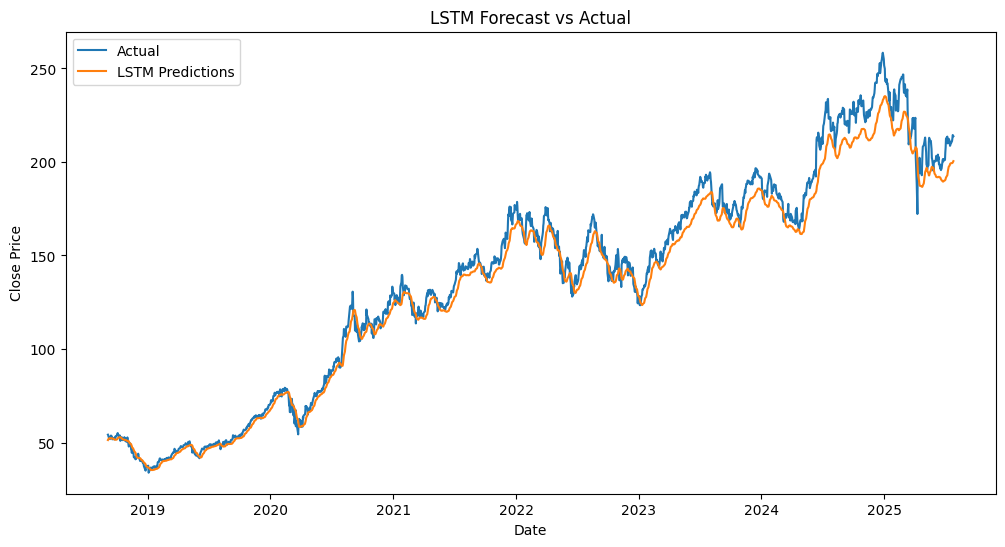

In [15]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(trainX, trainY, batch_size=10, epochs=3)

# Make predictions
lstm_pred = model_lstm.predict(testX)

# Inverse transform predictions to original scale
lstm_pred = scaler.inverse_transform(lstm_pred)

# Evaluate LSTM model
lstm_mae = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1, 1)), lstm_pred)
lstm_mse = mean_squared_error(scaler.inverse_transform(testY.reshape(-1, 1)), lstm_pred)
metrics['LSTM'] = {'MAE': lstm_mae, 'MSE': lstm_mse}

print(f"\nLSTM MAE: {lstm_mae}")
print(f"LSTM MSE: {lstm_mse}")

# Plot LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(df1.index[train_size+look_back+1:len(df1)], scaler.inverse_transform(testY.reshape(-1, 1)), label='Actual')
plt.plot(df1.index[train_size+look_back+1:len(df1)], lstm_pred, label='LSTM Predictions')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**PROPHET MODEL **

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj7jc5m6v/ojo5v33q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj7jc5m6v/yt7bzf2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69163', 'data', 'file=/tmp/tmpj7jc5m6v/ojo5v33q.json', 'init=/tmp/tmpj7jc5m6v/yt7bzf2u.json', 'output', 'file=/tmp/tmpj7jc5m6v/prophet_modelucvkjmne/prophet_model-20250803051456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet MAE: 24.781855885031863
Prophet MSE: 635.5503589682654

Updated Model Evaluation Metrics:


,MAE,MSE
LSTM,6.265580,69.354143
ARIMA,89.176638,11447.565690
SARIMA,72.629500,6808.820201
Prophet,24.781856,635.550359


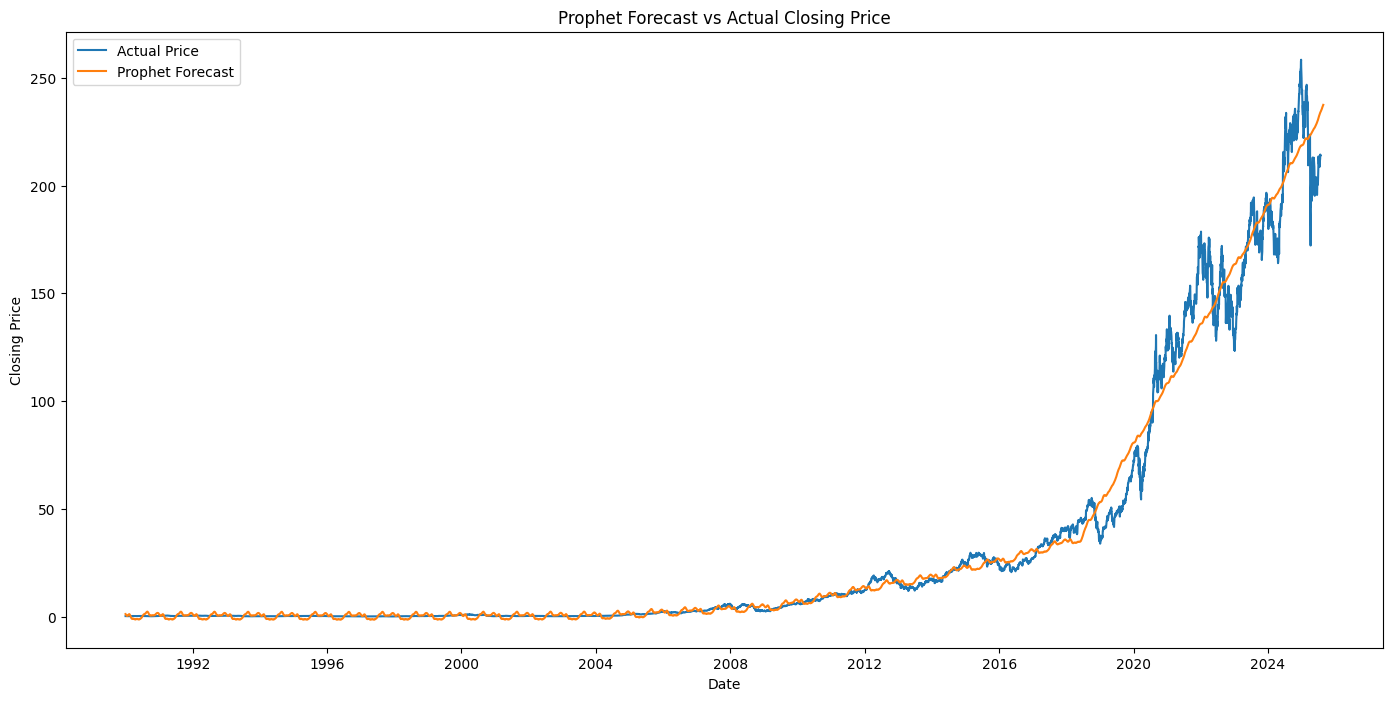

In [57]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
model_prophet = Prophet()

# Prepare data for Prophet - it requires columns named 'ds' (datetime) and 'y' (numeric)
# Use the original df dataframe and convert 'Date' to 'ds' and 'Close' to 'y'
prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
# Ensure 'ds' is timezone-naive datetime for Prophet
prophet_df['ds'] = pd.to_datetime(prophet_df['ds']).dt.tz_localize(None)

model_prophet.fit(prophet_df)

# Create a future dataframe for forecasting
future_dates = model_prophet.make_future_dataframe(periods=len(test))

# Make predictions
forecast = model_prophet.predict(future_dates)

test_for_eval = test[['ds', 'y']].copy()

# Merge test_for_eval with forecast to get actual values aligned with predictions
evaluation_df = pd.merge(test_for_eval, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate MAE and MSE
prophet_mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
prophet_mse = mean_squared_error(evaluation_df['y'], evaluation_df['yhat'])

# Add Prophet metrics to the metrics dictionary
metrics['Prophet'] = {'MAE': prophet_mae, 'MSE': prophet_mse}

print(f"\nProphet MAE: {prophet_mae}")
print(f"Prophet MSE: {prophet_mse}")

# Display the updated metrics table
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
print("\nUpdated Model Evaluation Metrics:")
display(metrics_df)

# Plot Prophet predictions
plt.figure(figsize=(17, 8))
plt.plot(df1.index, df1['Close'], label='Actual Price')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast')
plt.title("Prophet Forecast vs Actual Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

Model Evaluation Metrics:


,MAE,MSE
LSTM,6.265580,69.354143
ARIMA,89.176638,11447.565690
SARIMA,72.629500,6808.820201
Prophet,24.781856,635.550359


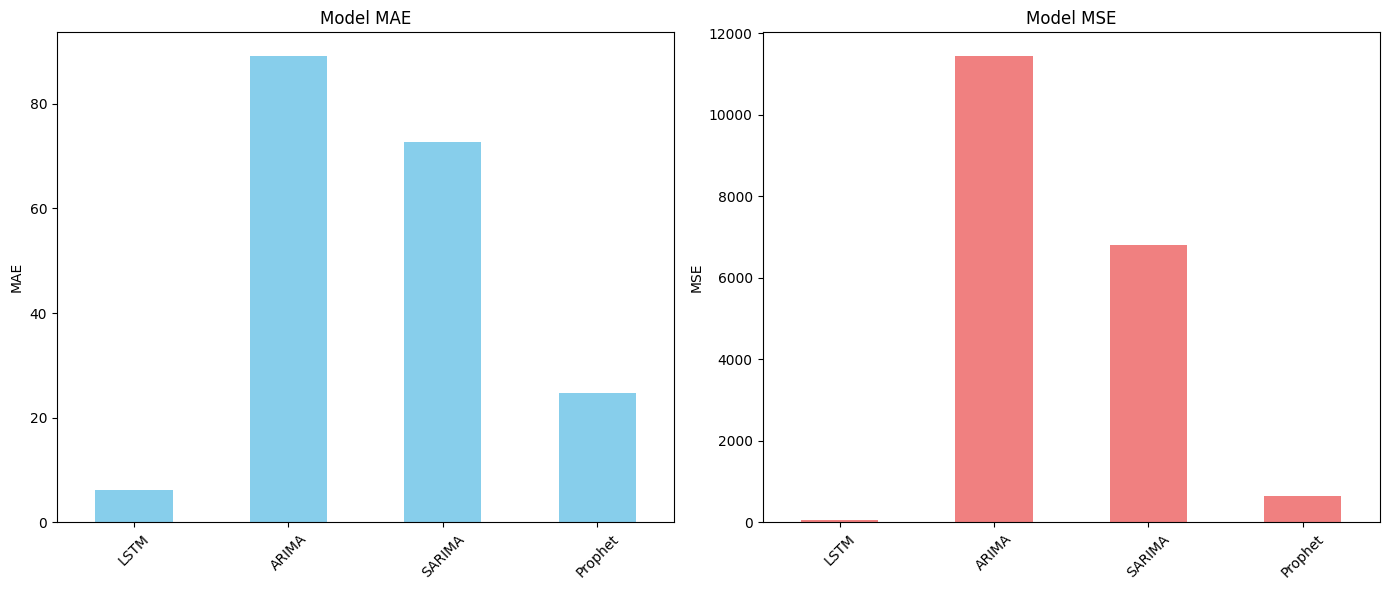

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
print("Model Evaluation Metrics:")
display(metrics_df)

# Plotting the evaluation metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics_df['MAE'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Model MAE')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

metrics_df['MSE'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Model MSE')
axes[1].set_ylabel('MSE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Test DataFrame head:
             ds           y
8927 2025-06-12  199.199997
8928 2025-06-13  196.449997
8929 2025-06-16  198.419998
8930 2025-06-17  195.639999
8931 2025-06-18  196.580002

Test DataFrame tail:
             ds           y
8952 2025-07-21  212.479996
8953 2025-07-22  214.399994
8954 2025-07-23  214.149994
8955 2025-07-24  213.759995
8956 2025-07-25  213.880005

Test DataFrame columns:
Index(['ds', 'y'], dtype='object')

Test DataFrame index:
RangeIndex(start=8927, stop=8957, step=1)


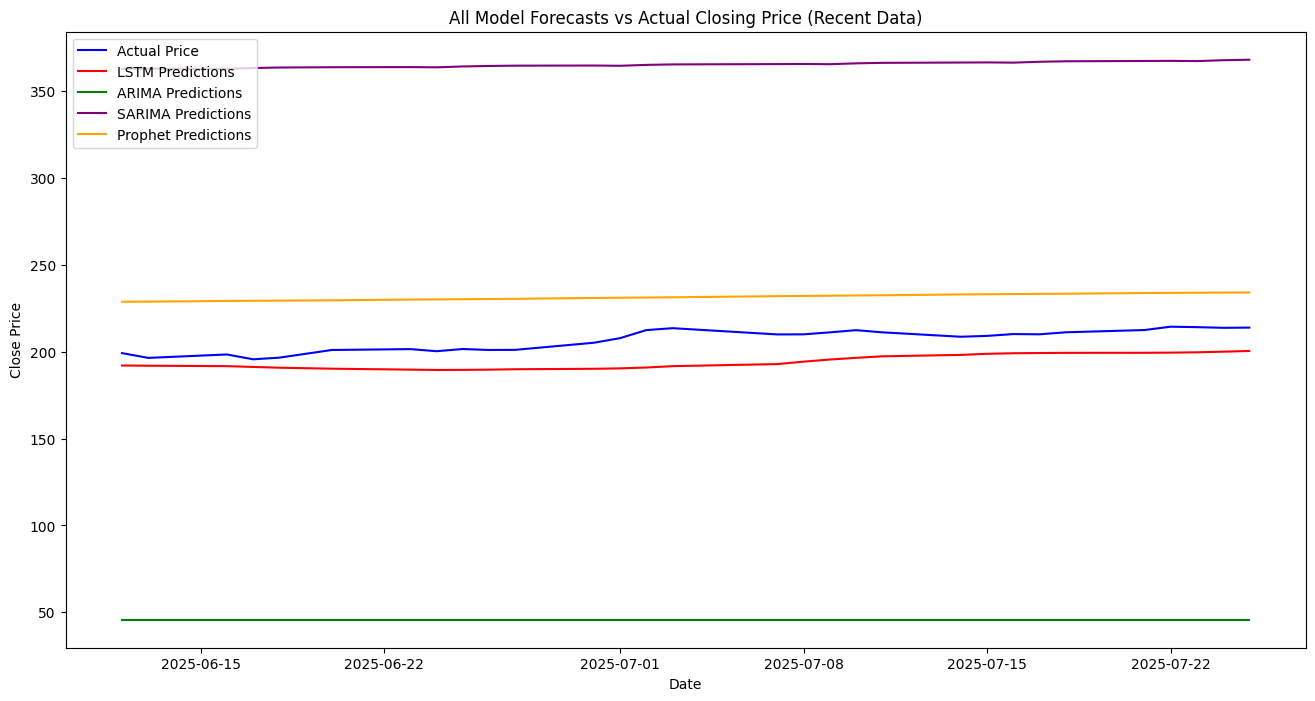

In [70]:
# Plot all Model Forecasts vs Actual Closing Price (Recent Data)

# Inspect the test DataFrame before plotting
print("Test DataFrame head:")
print(test.head())
print("\nTest DataFrame tail:")
print(test.tail())
print("\nTest DataFrame columns:")
print(test.columns)
print("\nTest DataFrame index:")
print(test.index)

plt.figure(figsize=(16, 8))

# Define a start date for recent data (e.g., start of the test set or a few years before)
# Using the start of the test set for consistency with predictions
recent_start_date = pd.to_datetime(test['ds']).dt.tz_localize(None).iloc[0]

# Filter the actual data to the recent period
actual_recent = test[pd.to_datetime(test['ds']).dt.tz_localize(None) >= recent_start_date].copy()
plt.plot(actual_recent['ds'], actual_recent['y'], label='Actual Price', color='blue')

# Filter LSTM predictions to the recent period
lstm_pred_index_naive = pd.to_datetime(df1.index[train_size + look_back + 1 : len(df1)]).tz_localize(None)
lstm_pred_recent = pd.Series(lstm_pred.flatten(), index=lstm_pred_index_naive)
lstm_pred_recent = lstm_pred_recent[lstm_pred_recent.index >= recent_start_date]
plt.plot(lstm_pred_recent.index, lstm_pred_recent, label='LSTM Predictions', color='red')

# Filter ARIMA predictions to the recent period
arima_predictions_index_naive = pd.to_datetime(arima_predictions.index).tz_localize(None)
arima_predictions_recent = pd.Series(arima_predictions.values, index=arima_predictions_index_naive)
arima_predictions_recent = arima_predictions_recent[arima_predictions_recent.index >= recent_start_date]
plt.plot(arima_predictions_recent.index, arima_predictions_recent, label='ARIMA Predictions', color='green')

# Filter SARIMA predictions to the recent period
sarima_predictions_index_naive = pd.to_datetime(sarima_predictions.index).tz_localize(None)
sarima_predictions_recent = pd.Series(sarima_predictions.values, index=sarima_predictions_index_naive)
sarima_predictions_recent = sarima_predictions_recent[sarima_predictions_recent.index >= recent_start_date]
plt.plot(sarima_predictions_recent.index, sarima_predictions_recent, label='SARIMA Predictions', color='purple')

# Filter Prophet predictions to the recent period
prophet_forecast_plot = forecast[forecast['ds'].isin(test['ds'])].copy()
prophet_forecast_plot['ds'] = pd.to_datetime(prophet_forecast_plot['ds']).dt.tz_localize(None)
prophet_forecast_plot_recent = prophet_forecast_plot[prophet_forecast_plot['ds'] >= recent_start_date]
plt.plot(prophet_forecast_plot_recent['ds'], prophet_forecast_plot_recent['yhat'], label='Prophet Predictions', color='orange')


plt.title('All Model Forecasts vs Actual Closing Price (Recent Data)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [71]:
# Ensure 'ds' columns are timezone-naive before merging

# 1. Create a new DataFrame called all_forecasts_df using the test DataFrame's 'ds' and 'y' columns, renaming 'y' to 'Actual'.
# Ensure 'ds' is timezone-naive
all_forecasts_df = test[['ds', 'y']].rename(columns={'y': 'Actual'}).copy()
all_forecasts_df['ds'] = pd.to_datetime(all_forecasts_df['ds']).dt.tz_localize(None)


# 2. Align the LSTM predictions (lstm_pred) with the dates in the test DataFrame by creating a temporary DataFrame with the LSTM predictions and the corresponding dates from df1.index. Rename the prediction column to 'LSTM_Pred'.
# The LSTM predictions correspond to the test set dates starting from train_size + look_back + 1
lstm_pred_dates = df1.index[train_size + look_back + 1 : len(df1)]
lstm_df = pd.DataFrame({'ds': lstm_pred_dates, 'LSTM_Pred': lstm_pred.flatten()})
lstm_df['ds'] = pd.to_datetime(lstm_df['ds']).dt.tz_localize(None) # Ensure 'ds' is timezone-naive

# 3. Merge the temporary LSTM DataFrame with all_forecasts_df on the date column.
all_forecasts_df = pd.merge(all_forecasts_df, lstm_df, on='ds', how='left')

# 4. Align the ARIMA predictions (arima_predictions) with the dates in the test DataFrame by creating a temporary DataFrame with the ARIMA predictions and the corresponding dates from test_arima.index. Rename the prediction column to 'ARIMA_Pred'.
# ARIMA predictions are aligned with the test set index
arima_df = pd.DataFrame({'ds': pd.to_datetime(arima_predictions.index).tz_localize(None), 'ARIMA_Pred': arima_predictions})


# 5. Merge the temporary ARIMA DataFrame with all_forecasts_df on the date column.
all_forecasts_df = pd.merge(all_forecasts_df, arima_df, on='ds', how='left')

# 6. Align the SARIMA predictions (sarima_predictions) with the dates in the test DataFrame by creating a temporary DataFrame with the SARIMA predictions and the corresponding dates from test_sarima.index. Rename the prediction column to 'SARIMA_Pred'.
# SARIMA predictions are aligned with the test set index
sarima_df = pd.DataFrame({'ds': pd.to_datetime(sarima_predictions.index).tz_localize(None), 'SARIMA_Pred': sarima_predictions})


# 7. Merge the temporary SARIMA DataFrame with all_forecasts_df on the date column.
all_forecasts_df = pd.merge(all_forecasts_df, sarima_df, on='ds', how='left')

# 8. Align the Prophet predictions (forecast_for_eval['yhat']) with the dates in the test DataFrame by creating a temporary DataFrame with the Prophet predictions and the corresponding dates from forecast_for_eval['ds']. Rename the prediction column to 'Prophet_Pred'.
# forecast_for_eval['ds'] was already made timezone-naive in the previous cell
prophet_df_pred = evaluation_df[['ds', 'yhat']].rename(columns={'yhat': 'Prophet_Pred'})


# 9. Merge the temporary Prophet DataFrame with all_forecasts_df on the date column.
all_forecasts_df = pd.merge(all_forecasts_df, prophet_df_pred, on='ds', how='left')

# 10. Create a new DataFrame called metrics_for_export from the metrics dictionary. Reset the index and rename the index column to 'Model'.
metrics_for_export = pd.DataFrame.from_dict(metrics, orient='index').reset_index().rename(columns={'index': 'Model'})

# 11. Print the head of all_forecasts_df and metrics_for_export to verify the data structure.
print("Head of all_forecasts_df:")
display(all_forecasts_df.head())
print("\nHead of metrics_for_export:")
display(metrics_for_export.head())

Head of all_forecasts_df:


,ds,Actual,LSTM_Pred,ARIMA_Pred,SARIMA_Pred,Prophet_Pred
0,2025-06-12,199.199997,192.090958,45.774226,362.822194,228.759400
1,2025-06-13,196.449997,191.946976,45.774226,362.894152,228.824832
2,2025-06-16,198.419998,191.702560,45.774226,362.762254,229.218744
3,2025-06-17,195.639999,191.233841,45.774226,363.263414,229.312633
4,2025-06-18,196.580002,190.799988,45.774226,363.545414,229.401748



Head of metrics_for_export:


,Model,MAE,MSE
0,LSTM,6.265580,69.354143
1,ARIMA,89.176638,11447.565690
2,SARIMA,72.629500,6808.820201
3,Prophet,24.781856,635.550359


Test DataFrame head:
             ds           y
8927 2025-06-12  199.199997
8928 2025-06-13  196.449997
8929 2025-06-16  198.419998
8930 2025-06-17  195.639999
8931 2025-06-18  196.580002

Test DataFrame tail:
             ds           y
8952 2025-07-21  212.479996
8953 2025-07-22  214.399994
8954 2025-07-23  214.149994
8955 2025-07-24  213.759995
8956 2025-07-25  213.880005

Test DataFrame columns:
Index(['ds', 'y'], dtype='object')

Test DataFrame index:
RangeIndex(start=8927, stop=8957, step=1)


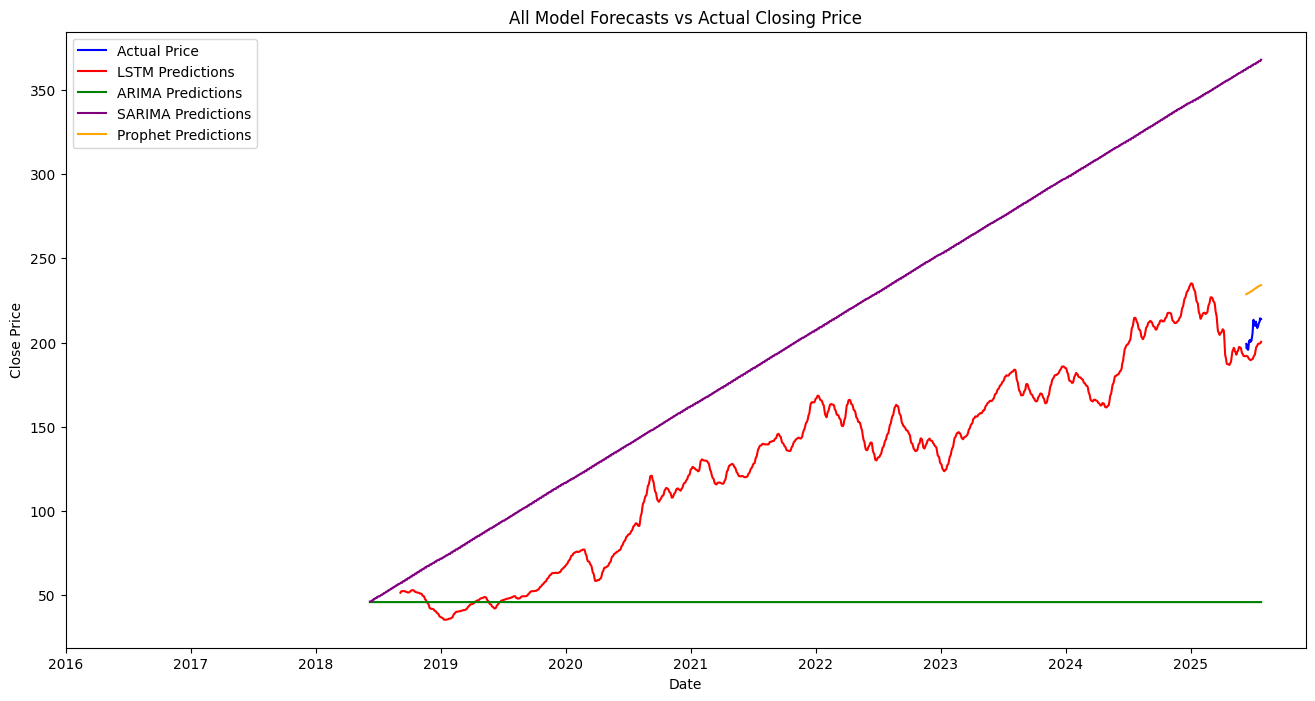

In [72]:
# Plot all Model Forecasts vs Actual Closing Price (Starting from a later date)

# Inspect the test DataFrame before plotting
print("Test DataFrame head:")
print(test.head())
print("\nTest DataFrame tail:")
print(test.tail())
print("\nTest DataFrame columns:")
print(test.columns)
print("\nTest DataFrame index:")
print(test.index)

plt.figure(figsize=(16, 8))
plt.plot(test['ds'], test['y'], label='Actual Price', color='blue')

# Plot LSTM predictions
lstm_pred_index = df1.index[train_size + look_back + 1 : len(df1)]
plt.plot(lstm_pred_index, lstm_pred, label='LSTM Predictions', color='red')

# Plot ARIMA predictions
plt.plot(arima_predictions.index, arima_predictions, label='ARIMA Predictions', color='green')

# Plot SARIMA predictions
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predictions', color='purple')

# Plot Prophet predictions
# Align Prophet predictions with the test set dates for plotting
prophet_forecast_plot = forecast[forecast['ds'].isin(test['ds'])].copy()
plt.plot(prophet_forecast_plot['ds'], prophet_forecast_plot['yhat'], label='Prophet Predictions', color='orange')

# Set x-axis limits to focus on a later period (e.g., from 2016 onwards)
plt.xlim(pd.to_datetime('2016-01-01'), plt.xlim()[1])


plt.title('All Model Forecasts vs Actual Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

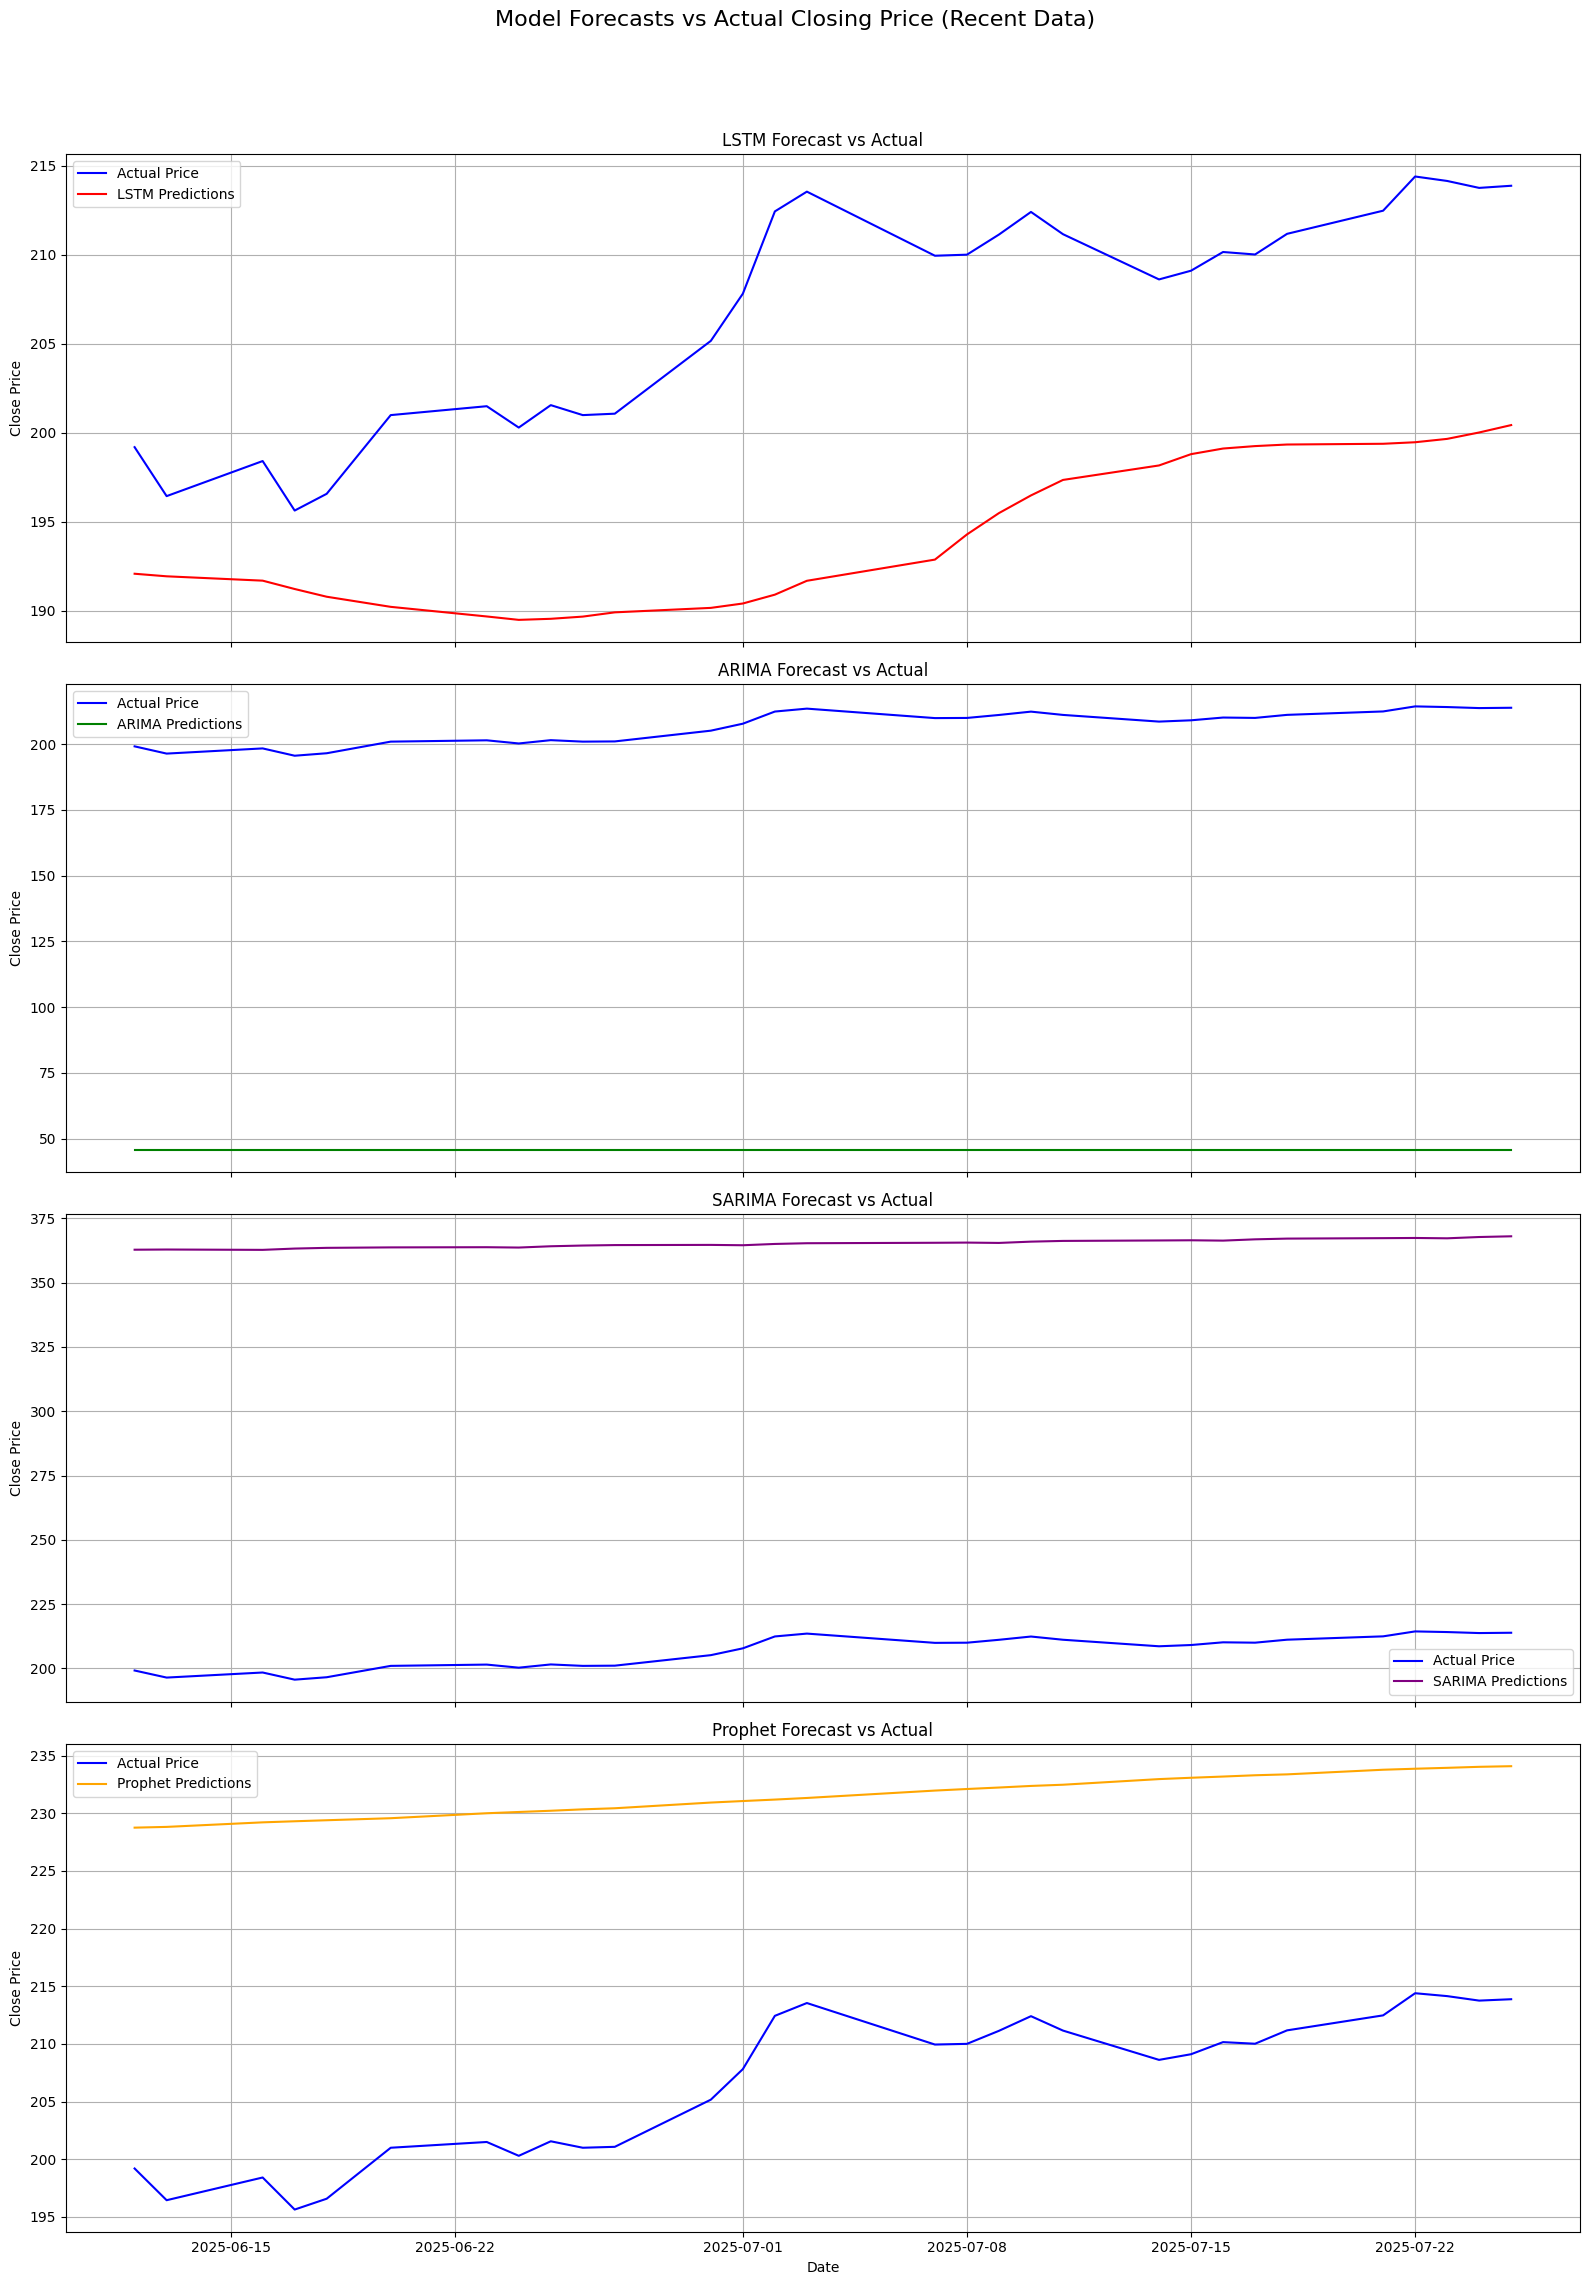

In [73]:
# Plot Actual vs. Predictions for Each Model in Subplots (Recent Data)

# Define a start date for recent data (using the start of the test set)
recent_start_date = pd.to_datetime(test['ds']).dt.tz_localize(None).iloc[0]

# Filter the actual data to the recent period
actual_recent = test[pd.to_datetime(test['ds']).dt.tz_localize(None) >= recent_start_date].copy()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 24), sharex=True)
fig.suptitle('Model Forecasts vs Actual Closing Price (Recent Data)', fontsize=16)

# Plot LSTM predictions
lstm_pred_index_naive = pd.to_datetime(df1.index[train_size + look_back + 1 : len(df1)]).tz_localize(None)
lstm_pred_recent = pd.Series(lstm_pred.flatten(), index=lstm_pred_index_naive)
lstm_pred_recent = lstm_pred_recent[lstm_pred_recent.index >= recent_start_date]
axes[0].plot(actual_recent['ds'], actual_recent['y'], label='Actual Price', color='blue')
axes[0].plot(lstm_pred_recent.index, lstm_pred_recent, label='LSTM Predictions', color='red')
axes[0].set_ylabel('Close Price')
axes[0].set_title('LSTM Forecast vs Actual')
axes[0].legend()
axes[0].grid(True)

# Plot ARIMA predictions
arima_predictions_index_naive = pd.to_datetime(arima_predictions.index).tz_localize(None)
arima_predictions_recent = pd.Series(arima_predictions.values, index=arima_predictions_index_naive)
arima_predictions_recent = arima_predictions_recent[arima_predictions_recent.index >= recent_start_date]
axes[1].plot(actual_recent['ds'], actual_recent['y'], label='Actual Price', color='blue')
axes[1].plot(arima_predictions_recent.index, arima_predictions_recent, label='ARIMA Predictions', color='green')
axes[1].set_ylabel('Close Price')
axes[1].set_title('ARIMA Forecast vs Actual')
axes[1].legend()
axes[1].grid(True)

# Plot SARIMA predictions
sarima_predictions_index_naive = pd.to_datetime(sarima_predictions.index).tz_localize(None)
sarima_predictions_recent = pd.Series(sarima_predictions.values, index=sarima_predictions_index_naive)
sarima_predictions_recent = sarima_predictions_recent[sarima_predictions_recent.index >= recent_start_date]
axes[2].plot(actual_recent['ds'], actual_recent['y'], label='Actual Price', color='blue')
axes[2].plot(sarima_predictions_recent.index, sarima_predictions_recent, label='SARIMA Predictions', color='purple')
axes[2].set_ylabel('Close Price')
axes[2].set_title('SARIMA Forecast vs Actual')
axes[2].legend()
axes[2].grid(True)

# Plot Prophet predictions
prophet_forecast_plot = forecast[forecast['ds'].isin(test['ds'])].copy()
prophet_forecast_plot['ds'] = pd.to_datetime(prophet_forecast_plot['ds']).dt.tz_localize(None)
prophet_forecast_plot_recent = prophet_forecast_plot[prophet_forecast_plot['ds'] >= recent_start_date]
axes[3].plot(actual_recent['ds'], actual_recent['y'], label='Actual Price', color='blue')
axes[3].plot(prophet_forecast_plot_recent['ds'], prophet_forecast_plot_recent['yhat'], label='Prophet Predictions', color='orange')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Close Price')
axes[3].set_title('Prophet Forecast vs Actual')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [74]:
# Save all_forecasts_df to CSV
all_forecasts_df.to_csv('stock_forecasts.csv', index=False)

# Save metrics_for_export to CSV
metrics_for_export.to_csv('model_metrics.csv', index=False)

print("DataFrames saved to stock_forecasts.csv and model_metrics.csv")

DataFrames saved to stock_forecasts.csv and model_metrics.csv


In [75]:
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
print("Model Evaluation Metrics:")
display(metrics_df)

Model Evaluation Metrics:


,MAE,MSE
LSTM,6.265580,69.354143
ARIMA,89.176638,11447.565690
SARIMA,72.629500,6808.820201
Prophet,24.781856,635.550359


### Model Performance Analysis and Summary

Based on the evaluation metrics (Mean Absolute Error - MAE and Mean Squared Error - MSE) and the generated plots comparing actual prices to model forecasts, we can analyze the performance of each time series model:


**Detailed Analysis:**

*   **LSTM (Long Short-Term Memory):**
    *   **Metrics:** The LSTM model shows the lowest MAE and MSE among all the models. This indicates that, on average, its predictions are closest to the actual values in the test set. The lower MSE also suggests smaller squared errors, giving less weight to large errors compared to ARIMA and SARIMA.
    *   **Plot:** The plot for the LSTM model shows that its predictions follow the general trend of the actual stock prices in the recent period reasonably well. It captures some of the fluctuations, although there are deviations.

*   **ARIMA (AutoRegressive Integrated Moving Average):**
    *   **Metrics:** The ARIMA model has the highest MAE and MSE by a significant margin. This suggests that its predictions are, on average, further away from the actual values compared to the other models. The high MSE indicates the presence of larger errors.
    *   **Plot:** The plot for the ARIMA model shows a relatively flat prediction line in the recent period, failing to capture the increasing trend and volatility of the stock prices. This is likely why its error metrics are so high.

*   **SARIMA (Seasonal AutoRegressive Integrated Moving Average):**
    *   **Metrics:** The SARIMA model has lower MAE and MSE than ARIMA but significantly higher than LSTM and Prophet. This indicates better performance than a simple ARIMA model, likely due to incorporating seasonality, but it still has considerable errors compared to the other models.
    *   **Plot:** The SARIMA plot shows a prediction line that is increasing over time, suggesting it captures some of the overall trend, but it does not closely follow the short-term fluctuations of the actual price in the recent period.

*   **Prophet:**
    *   **Metrics:** The Prophet model has the second-lowest MAE and MSE after LSTM. This suggests it provides reasonably accurate forecasts, better than both ARIMA and SARIMA, but not as precise as LSTM for this specific dataset and time period.
    *   **Plot:** The Prophet plot shows predictions that follow the general upward trend and exhibit some curvature, which is characteristic of the Prophet model's ability to capture trends and seasonality. While it doesn't capture all the sharp movements, it provides a more realistic forecast than ARIMA and SARIMA.

**Summary:**

Based on this analysis, the **LSTM model** appears to be the most effective among the tested models for forecasting the Apple stock prices in this dataset, demonstrating the lowest error metrics and a relatively good fit to the recent actual prices in the plot.

The **Prophet model** is the second-best performer, offering a decent balance between capturing trends and providing reasonable forecasts.

The **ARIMA** and **SARIMA** models, while fundamental time series methods, did not perform as well as LSTM and Prophet on this dataset, particularly in capturing the recent upward trend and volatility. This might suggest that for this specific stock data with its strong recent growth, models like LSTM and Prophet that can handle more complex patterns and non-linearities are more suitable.

It's important to note that model performance can vary depending on the dataset, the time period being forecasted, and the specific parameters used for each model. Further tuning of model parameters and exploring other time series models could potentially improve forecasting accuracy.